# Setup
## Imports

In [1]:
import os

import functools as f_tools

import matplotlib.pyplot as plt
import matplotlib.colors as mpl_c

import pandas as pd
import numpy as np

from sklearn.preprocessing import LabelEncoder
import tensorflow.keras as keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

## Load dataset

In [2]:
# Where is the data?
data_path = "data"

metadata_filename = "HAM10000_metadata.csv"
preprocesed_image_filenames = "hmnist_{resolution}_{resolution}_{depth}.csv"

In [3]:
# What data to load. change this for a different dataset
image_resolution = 28
color = True

depth = "RGB" if color else "L"
preprocesed_image_filename = preprocesed_image_filenames.format(resolution=image_resolution,depth=depth)

In [4]:
# Load data into dataframes
meta_df = pd.read_csv(data_path + os.sep + metadata_filename)
image_df = pd.read_csv(data_path + os.sep + preprocesed_image_filename)


# Initial visualization

In [5]:
meta_df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [6]:
image_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351,label
0,192,153,193,195,155,192,197,154,185,202,...,173,124,138,183,147,166,185,154,177,2
1,25,14,30,68,48,75,123,93,126,158,...,60,39,55,25,14,28,25,14,27,2
2,192,138,153,200,145,163,201,142,160,206,...,167,129,143,159,124,142,136,104,117,2
3,38,19,30,95,59,72,143,103,119,171,...,44,26,36,25,12,17,25,12,15,2
4,158,113,139,194,144,174,215,162,191,225,...,209,166,185,172,135,149,109,78,92,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,208,185,187,208,186,186,206,187,189,0
10011,2,3,1,38,33,32,121,104,103,132,...,96,79,76,24,23,21,3,4,1,0
10012,132,118,118,167,149,149,175,156,160,184,...,204,181,178,181,159,153,172,151,145,0
10013,160,124,146,164,131,152,167,127,146,169,...,185,162,167,184,157,166,185,162,172,0


# Clean data

In [7]:
# Remove ID labels, they do not contain interpretable information
meta_df = meta_df.drop(["lesion_id","image_id"], axis=1)

# Reorder meta_df columns
cols = meta_df.columns.tolist()

cols[0], cols[-1] = cols[-1], cols[0]
cols[1], cols[-2] = cols[-2], cols[1]

meta_df['age'] = meta_df.age.fillna(value=meta_df.age.mean())

meta_df = meta_df[cols]
meta_df

,localization,sex,age,dx_type,dx
0,scalp,male,80.0,histo,bkl
1,scalp,male,80.0,histo,bkl
2,scalp,male,80.0,histo,bkl
3,scalp,male,80.0,histo,bkl
4,ear,male,75.0,histo,bkl
...,...,...,...,...,...
10010,abdomen,male,40.0,histo,akiec
10011,abdomen,male,40.0,histo,akiec
10012,abdomen,male,40.0,histo,akiec
10013,face,male,80.0,histo,akiec


In [8]:
# Remove "label" from image df, this information is already in meta_df
image_df = image_df.drop(["label"], axis=1)
image_df

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
0,192,153,193,195,155,192,197,154,185,202,...,134,173,124,138,183,147,166,185,154,177
1,25,14,30,68,48,75,123,93,126,158,...,82,60,39,55,25,14,28,25,14,27
2,192,138,153,200,145,163,201,142,160,206,...,149,167,129,143,159,124,142,136,104,117
3,38,19,30,95,59,72,143,103,119,171,...,73,44,26,36,25,12,17,25,12,15
4,158,113,139,194,144,174,215,162,191,225,...,201,209,166,185,172,135,149,109,78,92
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10010,183,165,181,182,165,180,184,166,182,188,...,181,208,185,187,208,186,186,206,187,189
10011,2,3,1,38,33,32,121,104,103,132,...,129,96,79,76,24,23,21,3,4,1
10012,132,118,118,167,149,149,175,156,160,184,...,190,204,181,178,181,159,153,172,151,145
10013,160,124,146,164,131,152,167,127,146,169,...,165,185,162,167,184,157,166,185,162,172


# Visualize data once more (in more depth)
## Statistics

In [9]:
meta_df.describe()

,age
count,10015.000000
mean,51.863828
std,16.920252
min,0.000000
25%,40.000000
50%,50.000000
75%,65.000000
max,85.000000


In [10]:
meta_df[meta_df.columns.drop("age")].describe()

,localization,sex,dx_type,dx
count,10015,10015,10015,10015
unique,15,3,4,7
top,back,male,histo,nv
freq,2192,5406,5340,6705


In [11]:
image_df.describe()

,pixel0000,pixel0001,pixel0002,pixel0003,pixel0004,pixel0005,pixel0006,pixel0007,pixel0008,pixel0009,...,pixel2342,pixel2343,pixel2344,pixel2345,pixel2346,pixel2347,pixel2348,pixel2349,pixel2350,pixel2351
count,10015.000000,10015.000000,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,...,10015.000000,10015.00000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000,10015.000000
mean,181.056415,131.728407,141.24024,187.274488,137.089466,147.206191,192.358862,141.796405,152.211782,196.177234,...,148.545781,184.68657,138.416875,144.061508,178.656216,133.217474,138.752172,172.307239,127.871193,133.144483
std,59.746698,45.043473,48.67267,54.021274,41.138096,44.661091,48.267713,37.382709,40.725174,43.892249,...,37.018206,47.02376,38.393007,41.322365,53.534096,42.910723,45.642257,58.533979,46.453818,49.060028
min,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,158.000000,117.000000,123.00000,165.000000,122.000000,130.000000,170.000000,127.000000,135.000000,174.000000,...,129.000000,166.00000,123.000000,126.000000,160.000000,118.000000,120.000000,153.000000,113.000000,115.000000
50%,198.000000,141.000000,151.00000,201.000000,144.000000,155.000000,204.000000,146.000000,157.000000,205.000000,...,151.000000,197.00000,144.000000,149.000000,195.000000,141.000000,146.000000,191.000000,138.000000,142.000000
75%,224.000000,159.000000,172.00000,226.000000,162.000000,174.000000,227.000000,163.000000,177.000000,228.000000,...,171.000000,216.00000,161.000000,169.000000,214.000000,159.000000,166.000000,212.000000,156.000000,163.000000
max,255.000000,246.000000,255.00000,254.000000,246.000000,254.000000,255.000000,251.000000,255.000000,255.000000,...,254.000000,255.00000,254.000000,254.000000,254.000000,252.000000,255.000000,254.000000,249.000000,254.000000


## Plots
### Meta

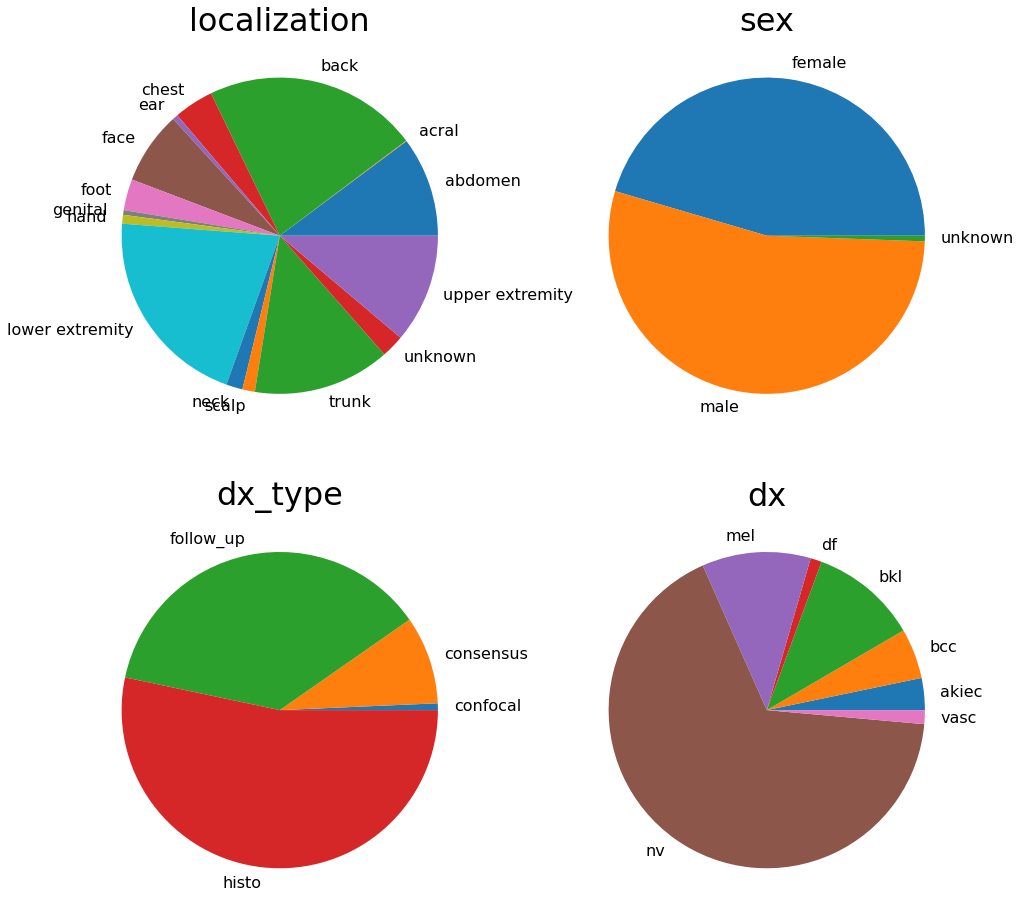

In [12]:
plot_size = 16
textprops = dict(fontsize=plot_size)

categorical_columns =  meta_df.columns.drop("age")

n_pies = len(categorical_columns)
cols = n_pies//2
rows = min(n_pies//2, n_pies//2 + 1, key=lambda x: abs(x - n_pies/2))

fig, axs = plt.subplots(cols,rows)

for i, cc in enumerate(categorical_columns):
    ax = axs[i//2,i%2]
    
    c = meta_df.groupby(cc).size()
    counts = c
    labels = c.keys()
    
    ax.pie(counts,labels=labels,textprops=textprops)
    ax.set_title(cc,fontsize=plot_size*2)
    
fig.set_size_inches(plot_size,plot_size)
plt.show()

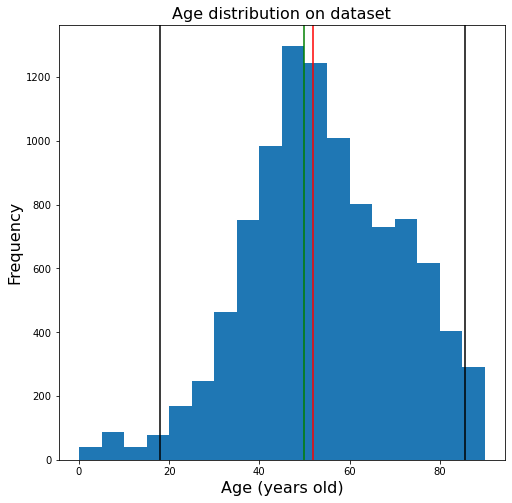

In [13]:
plot_size = 8
std_span = 2 # >75 % data (Chebyshev’s Theorem), > 95% on normal distributions

fig, ax = plt.subplots()

ax.hist(meta_df.age, bins=np.arange(0,95,5))

ax.set_title("Age distribution on dataset",fontsize=plot_size*2)
ax.set_xlabel("Age (years old)",fontsize=plot_size*2)
ax.set_ylabel("Frequency",fontsize=plot_size*2)

age_mean = meta_df.age.mean()
age_std = meta_df.age.std()

ax.axvline(age_mean, color="red") # Mean line
ax.axvline(meta_df.age.median(), color="green") # Median line

ax.axvline(age_mean - age_std*std_span, color="black") # Std lines
ax.axvline(age_mean + age_std*std_span, color="black") 


fig.set_size_inches(plot_size,plot_size)

### Image

In [14]:
img_cols = image_df.columns.tolist()

color_cols = {}
color_cols["Red"] = img_cols[::3]
color_cols["Green"] = img_cols[1::3]
color_cols["Blue"] = img_cols[2::3]

color_dfs = {k : image_df[v] for k,v in color_cols.items()}

In [15]:
## Define metrics
metrics = {}
metrics["mean"] = pd.DataFrame.mean
metrics["median"] = pd.DataFrame.median
metrics["std"] = pd.DataFrame.std
metrics["max"] = pd.DataFrame.max
metrics["min"] = pd.DataFrame.min


#### Image level

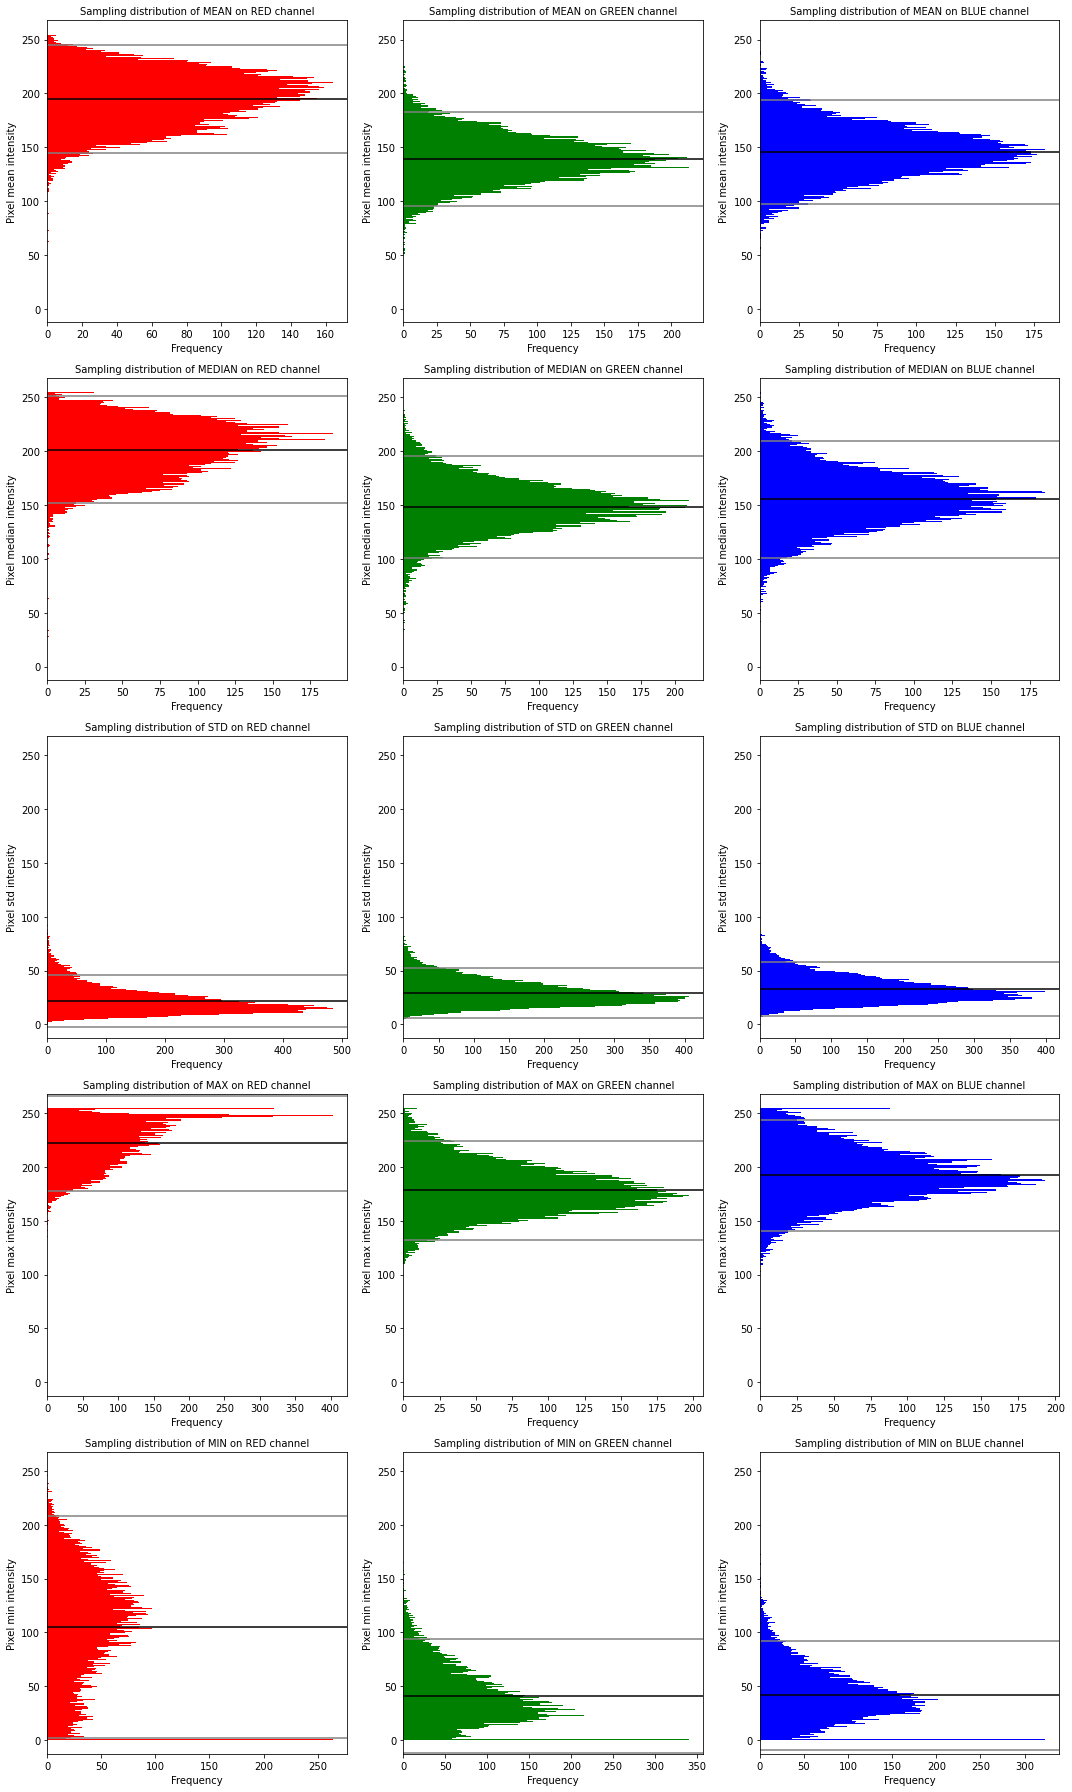

In [16]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df,axis=1)
        ax.hist(dist, bins=bins, color=col_name, orientation="horizontal")
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        mean = dist.mean()
        std = dist.std()
        ax.axhline(mean, color="black") # Mean line

        ax.axhline(mean - std*std_span, color="grey") # Std lines
        ax.axhline(mean + std*std_span, color="grey") 
        

fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

#### Pixel level

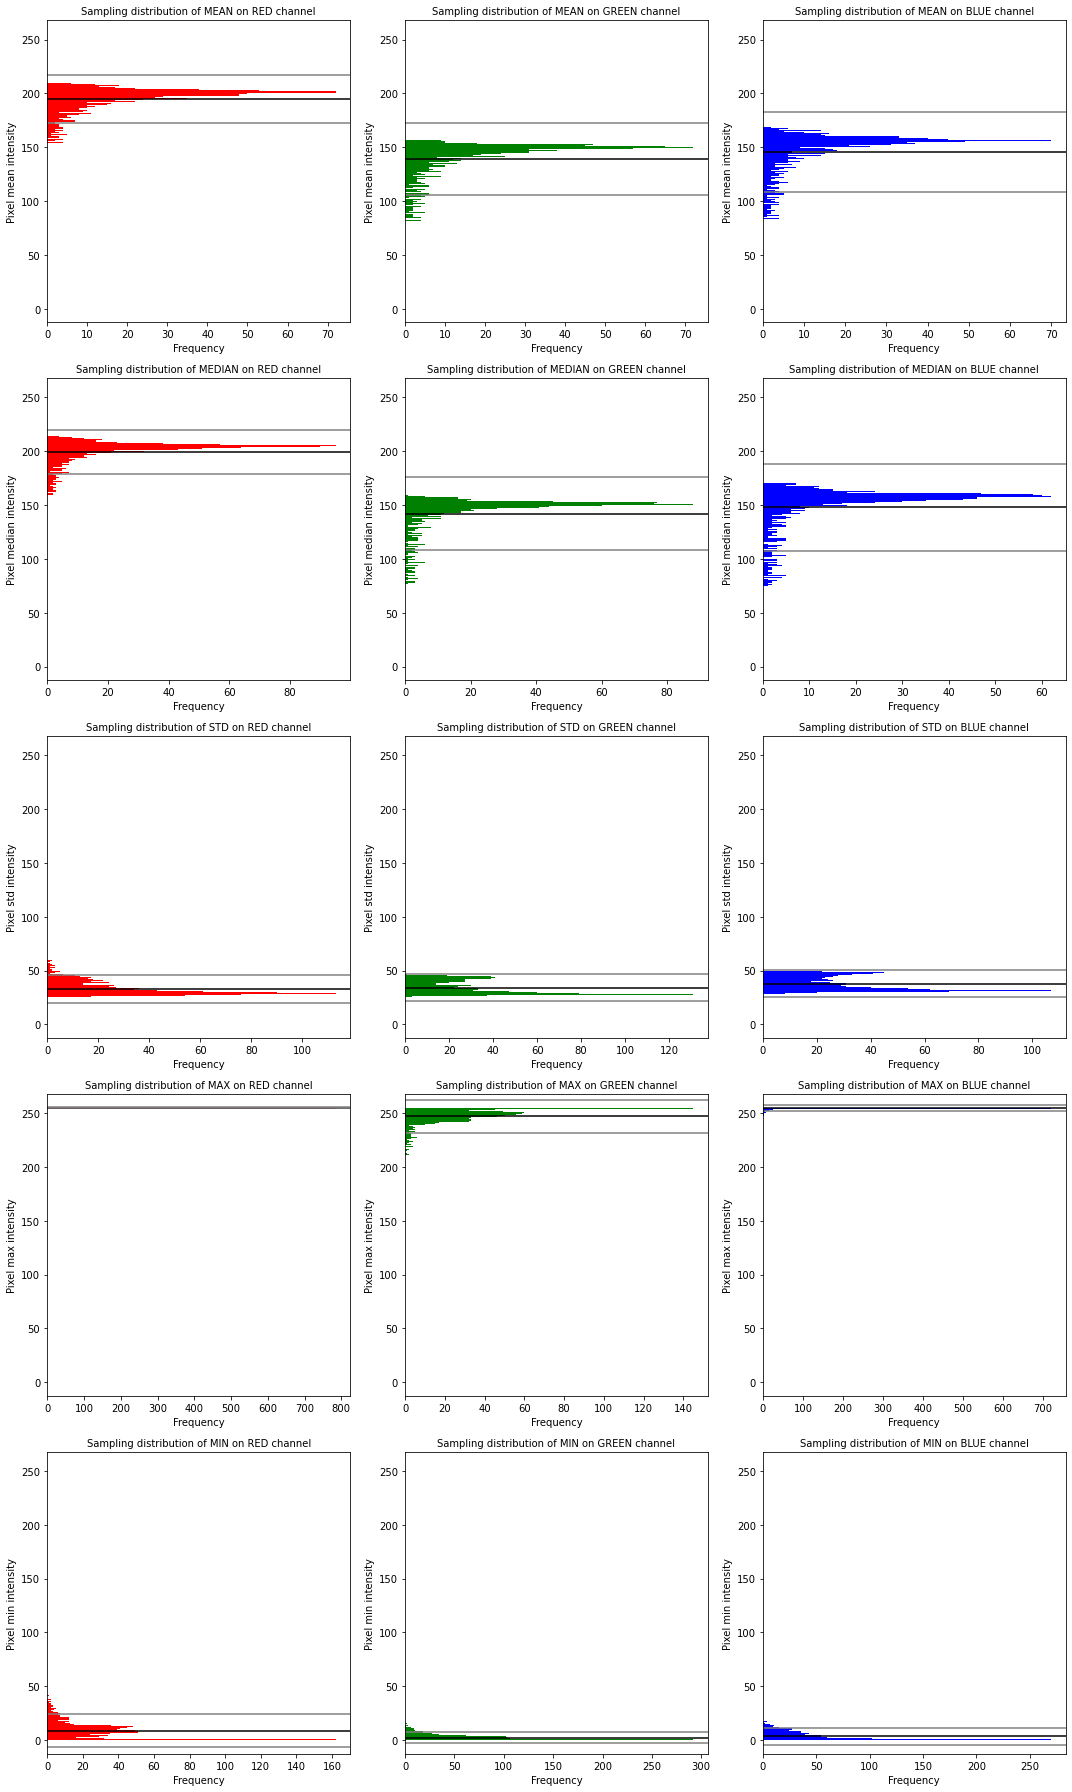

In [17]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df)
        ax.hist(dist, bins=bins, color=col_name, orientation="horizontal")
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        mean = dist.mean()
        std = dist.std()
        ax.axhline(mean, color="black") # Mean line

        ax.axhline(mean - std*std_span, color="grey") # Std lines
        ax.axhline(mean + std*std_span, color="grey") 
        
fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

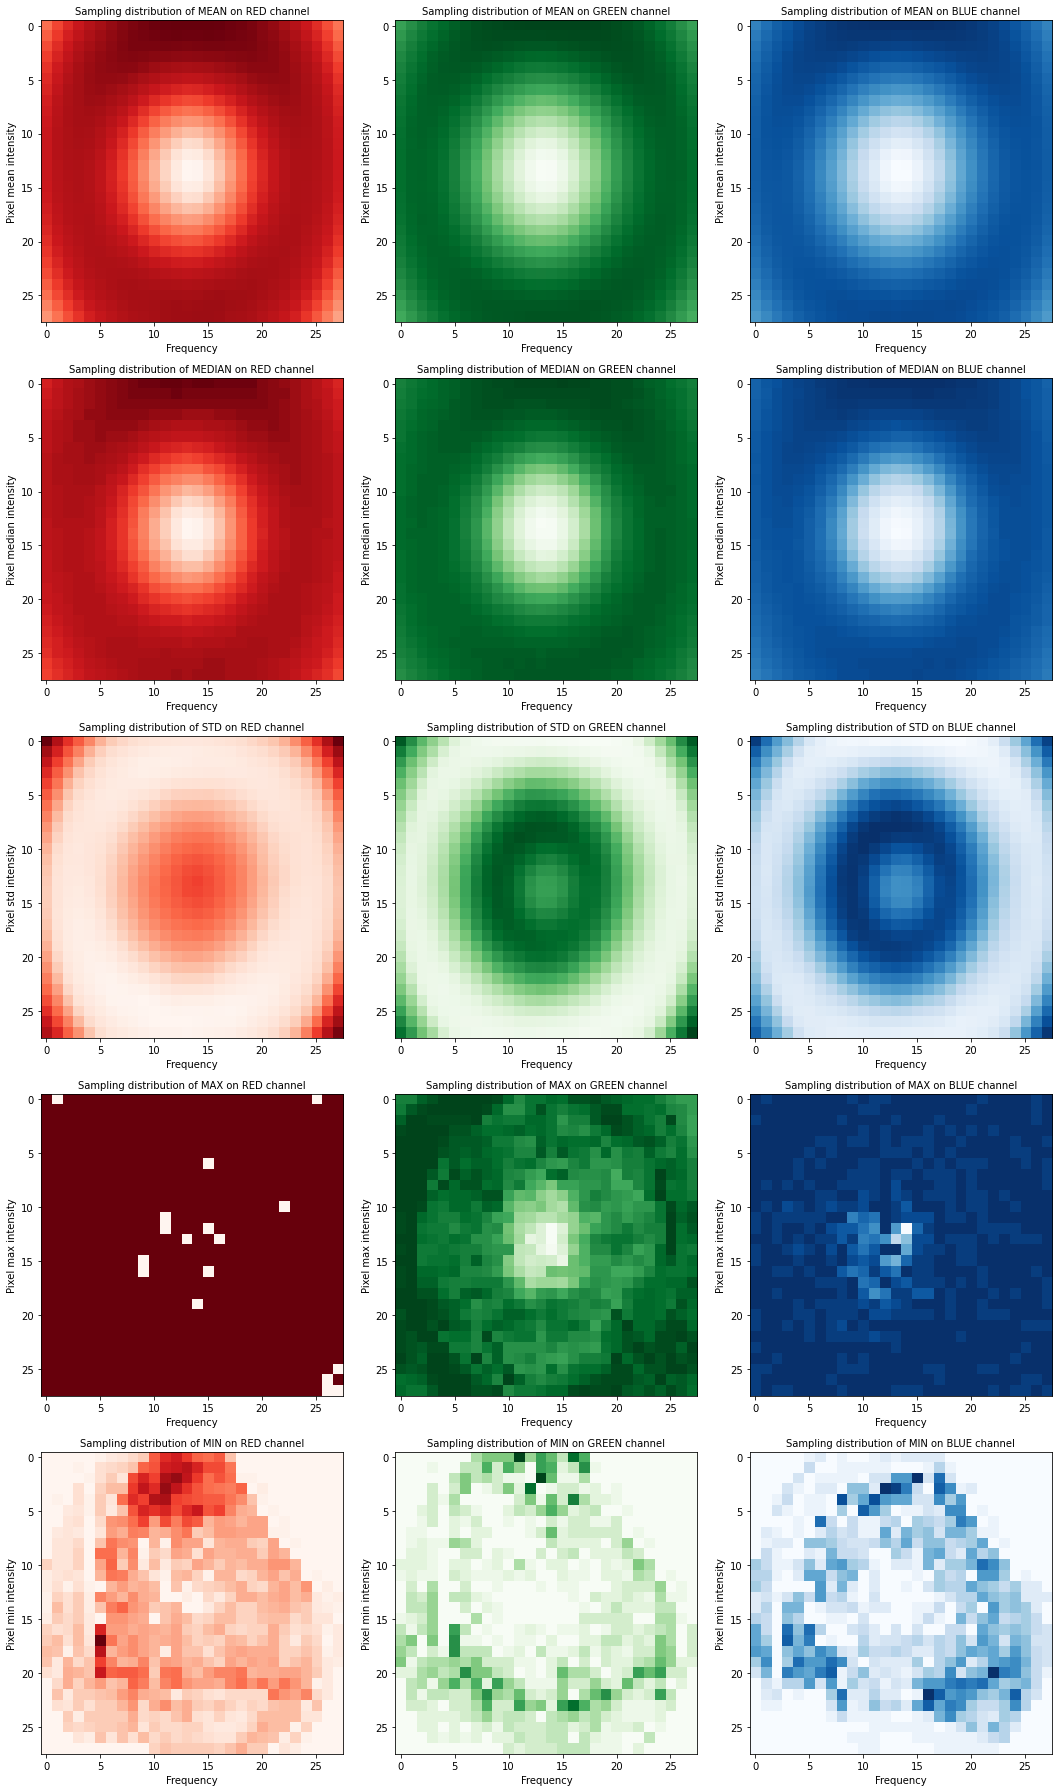

In [18]:
plot_scale = 5
std_span = 2

bins = np.arange(0,256,1)
fig, axs = plt.subplots(len(metrics),len(color_dfs))

for i, (col_name, col_df) in enumerate(color_dfs.items()):
    for j, (metric_name, metric) in enumerate(metrics.items()):
        ax = axs[j,i]
        
        dist = metric(col_df)
        dist = dist.to_numpy()
        
        dist_img = np.reshape(dist,(image_resolution,image_resolution))
        
        ax.imshow(dist_img,cmap=col_name+'s')
        
        ax.set_title("Sampling distribution of {} on {} channel".format(metric_name.upper(),col_name.upper()),fontsize=plot_scale*2)
        ax.set_ylabel("Pixel {} intensity".format(metric_name),fontsize=plot_scale*2)
        ax.set_xlabel("Frequency",fontsize=plot_scale*2)
        
        
fig.set_size_inches(plot_scale*len(color_dfs),plot_scale*len(metrics))
fig.tight_layout()

# Preprocessing

In [19]:
meta_df.head()

,localization,sex,age,dx_type,dx
0,scalp,male,80.0,histo,bkl
1,scalp,male,80.0,histo,bkl
2,scalp,male,80.0,histo,bkl
3,scalp,male,80.0,histo,bkl
4,ear,male,75.0,histo,bkl


In [20]:
meta_df.shape

(10015, 5)

In [21]:
target = meta_df.dx
len(set(target))

7

In [22]:
meta_df.head()

,localization,sex,age,dx_type,dx
0,scalp,male,80.0,histo,bkl
1,scalp,male,80.0,histo,bkl
2,scalp,male,80.0,histo,bkl
3,scalp,male,80.0,histo,bkl
4,ear,male,75.0,histo,bkl


In [23]:
#categorical columns
cat_df = meta_df.drop(['age'], axis = 1) 
num_df = (meta_df.age - meta_df.age.mean()) / meta_df.age.std() # Normalize distribution

In [24]:
le = LabelEncoder()
cat_df_e = cat_df.apply(LabelEncoder().fit_transform)
meta_df_e = pd.concat([cat_df_e.iloc[:,:-1], num_df, cat_df_e.iloc[:,-1]], axis=1)
meta_df_e.head()

,localization,sex,dx_type,age,dx
0,11,1,3,1.662870,2
1,11,1,3,1.662870,2
2,11,1,3,1.662870,2
3,11,1,3,1.662870,2
4,4,1,3,1.367366,2


In [25]:
image_df_e = (image_df - image_df.mean())/image_df.std()

In [26]:
shuffled_meta = meta_df_e.sample(frac=1)
shuffled_img = image_df_e.iloc[shuffled_meta.index]

In [27]:
# split
test_split = 0.3
test_size = int(len(shuffled_meta)*test_split)

meta_train = shuffled_meta.iloc[test_size:,:]
meta_test = shuffled_meta.iloc[:test_size,:]

img_train = shuffled_img.iloc[test_size:,:]
img_test = shuffled_img.iloc[:test_size,:]

In [28]:
X_train, y_train = ([meta_train.iloc[:,x] for x in range(len(meta_train.columns)-1)]
                    +[img_train],
                    meta_train.iloc[:,-1])
X_test, y_test = ([meta_test.iloc[:,x] for x in range(len(meta_test.columns)-1)]
                    +[img_test],
                    meta_test.iloc[:,-1])

# Baselines

In [233]:
class PrintLayer(keras.layers.Layer):
    def __init__(self):
        super().__init__()
        
    def call(self,input_):
        tf.print(input_)
        return input_

In [353]:
filter_count = 32
conv_per_pooling = 1
pooling_iterations = 3
conv_dropout_rate = 0.4
conv_activation = "relu"

hidden_units = 64
intermediate_layer_count = 1
activations="relu"
dropout_rate = 0.3

# Inputs
localization_in = keras.Input(shape=1, name="Localization_input")
sex_in = keras.Input(shape=1, name="Sex_input")
dx_type_in = keras.Input(shape=1, name="Dx_type_input")
age_in = keras.Input(shape=1, name="Age_input")
pics_in = keras.Input(shape=image_df.shape[1], name="Picture_input")

# Input representations
## Embedding
localization_rep = keras.layers.Embedding(input_dim=len(meta_df_e.localization.unique()), 
                                             output_dim=hidden_units, 
                                             name="localization_embedding")(localization_in)
localization_rep = keras.layers.Flatten(name="flatten_localization")(localization_rep)

sex_rep = keras.layers.Embedding(input_dim=len(meta_df_e.sex.unique()), 
                                    output_dim=hidden_units, 
                                    name="sex_embedding")(sex_in)
sex_rep = keras.layers.Flatten(name="flatten_sex")(sex_rep)

dx_type_rep = keras.layers.Embedding(input_dim=len(meta_df_e.dx_type.unique()), 
                                        output_dim=hidden_units, 
                                        name="dx_type_embedding")(dx_type_in)
dx_type_rep = keras.layers.Flatten(name="flatten_dx_type")(dx_type_rep)

## Fully Connected
age_rep = keras.layers.Dense(units=hidden_units,activation=activations, 
                             name="age_dense")(age_in)
"""
pic_rep = keras.layers.Dense(units=hidden_units, 
                                activation=activations, 
                                name="pics_dense")(pics_in)
"""
## Convolutional
### Extract channels
pic_r = pics_in[:,::3]
pic_g = pics_in[:,1::3]
pic_b = pics_in[:,2::3]

### Unflatten
pic_r = keras.layers.Reshape((image_resolution,image_resolution,1),name="red_channel2matrix")(pic_r)
pic_g = keras.layers.Reshape((image_resolution,image_resolution,1),name="green_channel2matrix")(pic_g)
pic_b = keras.layers.Reshape((image_resolution,image_resolution,1),name="blue_channel2matrix")(pic_b)

### Build up images
pic_rgb = keras.layers.Concatenate()([pic_r,pic_g,pic_b])
print(pic_rgb.shape)

### Apply convolutional reduction
pic_rep = pic_rgb
for pool_i in range(pooling_iterations):
    for conv_i in range(conv_per_pooling):
        pic_rep = keras.layers.Conv2D(filter_count,3,padding="same",activation=conv_activation)(pic_rep)
    pic_rep = keras.layers.MaxPool2D()(pic_rep)
    pic_rep = keras.layers.BatchNormalization()(pic_rep)
    pic_rep = keras.layers.Dropout(rate=conv_dropout_rate)(pic_rep)
    print(pic_rep.shape)

### Last layer (fully convolutional)
pic_rep = keras.layers.Conv2D(hidden_units,3,padding="same",activation=conv_activation)(pic_rep)
pic_rep = keras.layers.MaxPool2D(pic_rep.shape[1:3])(pic_rep) # Pool everything left
pic_rep = keras.layers.Flatten()(pic_rep)

#pic_rep = keras.layers.Dense(units=hidden_units,
#                             activation=activations,)(pic_rep)


# Combine representations
input_representations = [localization_rep, sex_rep, dx_type_rep, age_rep, pic_rep] 
combined_rep = keras.layers.Add(name="add_representations")(input_representations)

# Regularize
combined_rep = keras.layers.BatchNormalization(name="initial_layer_normalization")(combined_rep)


# Apply intermediate layers
for i_layer in range(intermediate_layer_count):
    combined_rep = keras.layers.Dropout(rate=dropout_rate,
                                    name=f"intermediate_layer_dropout_f{i_layer}")(combined_rep)
    combined_rep = keras.layers.Dense(units=hidden_units, 
                                      activation=activations, 
                                      name=f"Intermediate_dense_{i_layer}")(combined_rep)
    combined_rep = keras.layers.BatchNormalization(name=f"intermediate_layer_normalization_{i_layer}")(combined_rep)
    
    
    
# Output layers
output = keras.layers.Dense(units=len(meta_df_e.dx.unique()), 
                            activation="linear",
                            name="output_dense")(combined_rep)
output = keras.layers.Softmax(name="final_softmax")(output)


# Define model
model = keras.Model(inputs=[localization_in, sex_in, dx_type_in, age_in, pics_in], outputs=output, name="CancerNN")

(None, 28, 28, 3)
(None, 14, 14, 32)
(None, 7, 7, 32)
(None, 3, 3, 32)


In [354]:
model.summary()

Model: "CancerNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Picture_input (InputLayer)      [(None, 2352)]       0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_734 (S (None, 784)          0           Picture_input[0][0]              
__________________________________________________________________________________________________
tf.__operators__.getitem_735 (S (None, 784)          0           Picture_input[0][0]              
__________________________________________________________________________________________________
tf.__operators__.getitem_736 (S (None, 784)          0           Picture_input[0][0]              
___________________________________________________________________________________________

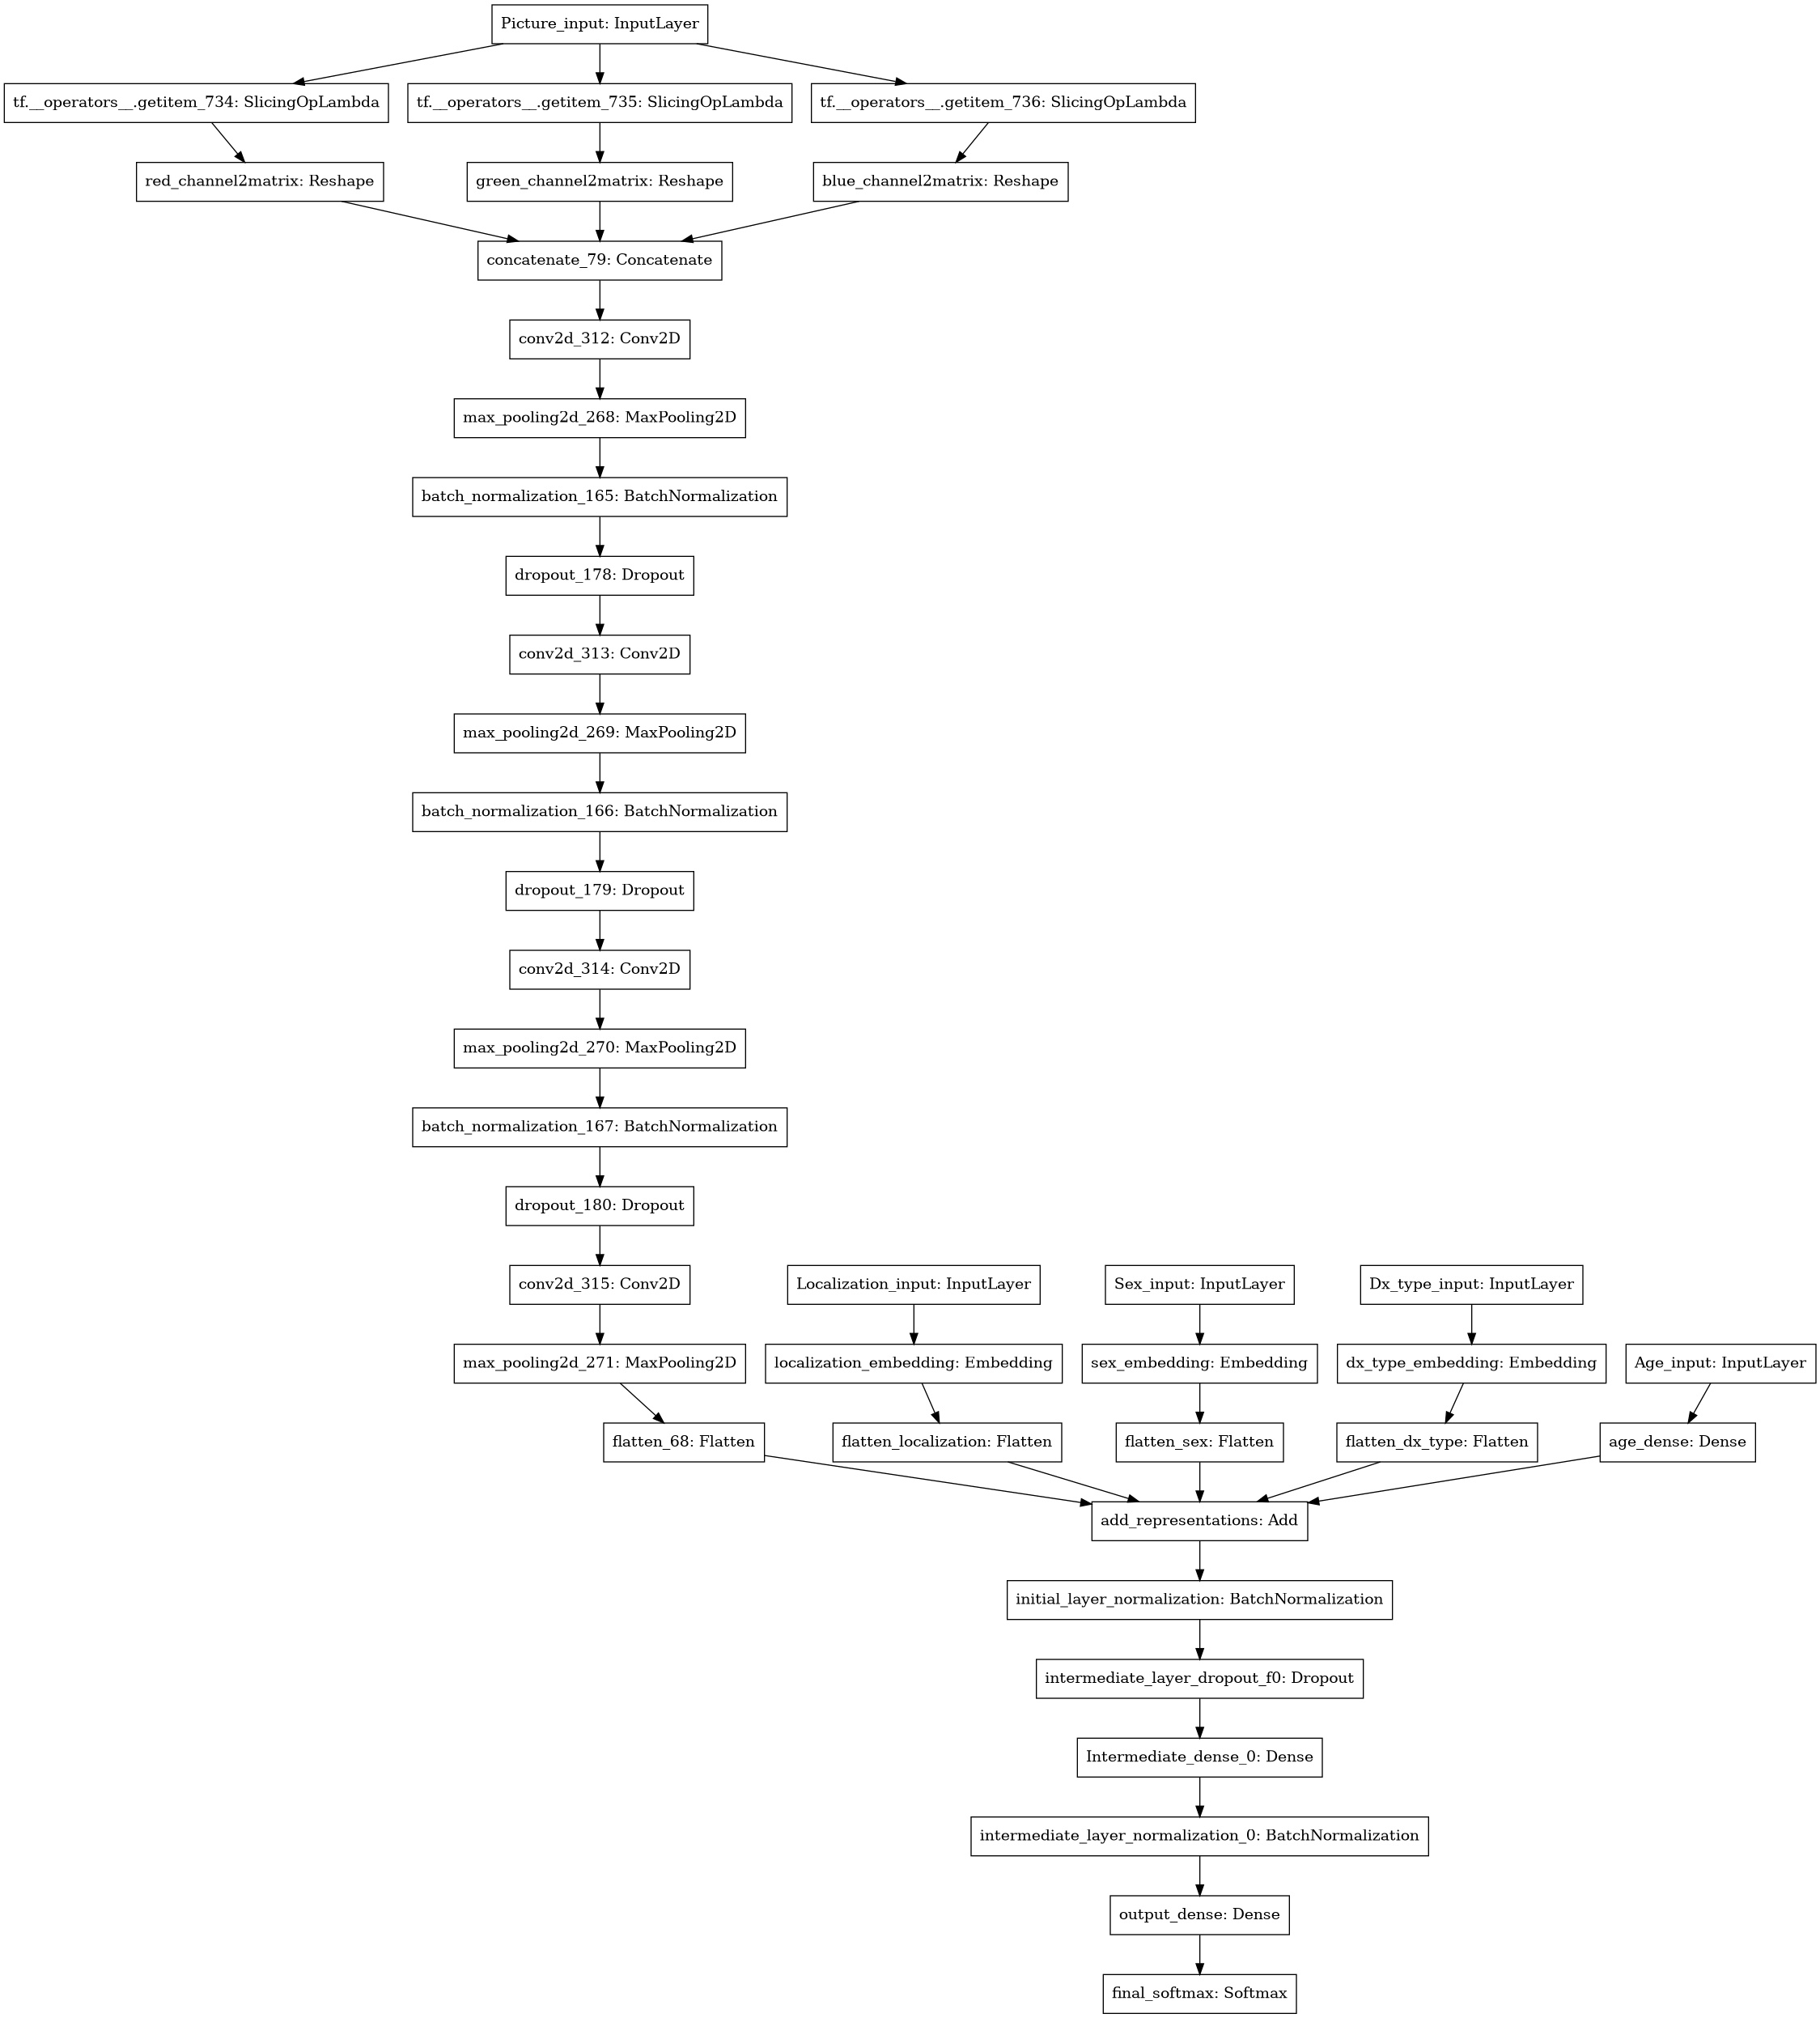

In [355]:
keras.utils.plot_model(model)

In [356]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

## Upper Baseline

In [357]:
model.fit(X_train, y_train,
            shuffle=True,
            batch_size=64,
            epochs=300,
            validation_data=(X_test,y_test),
            verbose=1)

Epoch 1/300
110/110 [==============================] - 2s 8ms/step - loss: 1.6176 - accuracy: 0.4844 - val_loss: 1.0513 - val_accuracy: 0.7107
Epoch 2/300
110/110 [==============================] - 1s 7ms/step - loss: 1.0395 - accuracy: 0.6641 - val_loss: 0.8479 - val_accuracy: 0.7217
Epoch 3/300
110/110 [==============================] - 1s 7ms/step - loss: 0.8646 - accuracy: 0.6965 - val_loss: 0.7922 - val_accuracy: 0.7207
Epoch 4/300
110/110 [==============================] - 1s 7ms/step - loss: 0.8073 - accuracy: 0.7140 - val_loss: 0.7349 - val_accuracy: 0.7407
Epoch 5/300
110/110 [==============================] - 1s 7ms/step - loss: 0.7684 - accuracy: 0.7223 - val_loss: 0.7059 - val_accuracy: 0.7437
Epoch 6/300
110/110 [==============================] - 1s 7ms/step - loss: 0.7465 - accuracy: 0.7246 - val_loss: 0.6565 - val_accuracy: 0.7593
Epoch 7/300
110/110 [==============================] - 1s 7ms/step - loss: 0.7191 - accuracy: 0.7363 - val_loss: 0.6317 - val_accuracy: 0.7643

## Lower Baseline

In [358]:
model = keras.models.clone_model(model)
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(),
            optimizer=keras.optimizers.Adam(),
            metrics=['accuracy'])

In [359]:
annotated_ratio = 0.1 
train_size = int(len(y_train)*annotated_ratio)

model.fit([col.iloc[:train_size] for col in X_train],
            y_train.iloc[:train_size],
            shuffle=True,
            batch_size=64,
            epochs=300,
            validation_data=(X_test,y_test))

Epoch 1/300
11/11 [==============================] - 1s 43ms/step - loss: 2.2995 - accuracy: 0.2340 - val_loss: 1.8803 - val_accuracy: 0.4254
Epoch 2/300
11/11 [==============================] - 0s 17ms/step - loss: 2.0208 - accuracy: 0.3880 - val_loss: 1.7449 - val_accuracy: 0.6255
Epoch 3/300
11/11 [==============================] - 0s 17ms/step - loss: 1.8605 - accuracy: 0.4408 - val_loss: 1.6477 - val_accuracy: 0.6811
Epoch 4/300
11/11 [==============================] - 0s 19ms/step - loss: 1.6994 - accuracy: 0.4665 - val_loss: 1.5723 - val_accuracy: 0.7011
Epoch 5/300
11/11 [==============================] - 0s 18ms/step - loss: 1.5988 - accuracy: 0.5136 - val_loss: 1.4870 - val_accuracy: 0.6977
Epoch 6/300
11/11 [==============================] - 0s 18ms/step - loss: 1.5119 - accuracy: 0.5178 - val_loss: 1.4074 - val_accuracy: 0.7037
Epoch 7/300
11/11 [==============================] - 0s 18ms/step - loss: 1.3849 - accuracy: 0.5806 - val_loss: 1.3077 - val_accuracy: 0.7087
Epoch 

# Pseudo-Labelling

In [360]:
class PseudoLabeller():
    def __init__(self, model, train_data, annotated_ratio, compile_args):
        self.model = model
        self.train_data = train_data
        self.annotated_ratio = annotated_ratio
        self.compile_args = compile_args
    
    def fit(self):
        self.base_model = keras.models.clone_model(self.model) # clone
        self.base_model.compile(**self.compile_args) # compile

        X_train, y_train = self.train_data # save split
        train_size = int(len(y_train)*self.annotated_ratio)
        
        self.base_model.fit([col.iloc[:train_size] for col in X_train],
                    y_train.iloc[:train_size],
                    shuffle=True,
                    batch_size=32,
                    epochs=20)
        
        # compute pseudo-labels
        self.pseudo_y = self.base_model.predict([col.iloc[train_size:] for col in X_train])
        self.pseudo_y = pd.Series(np.argmax(self.pseudo_y, axis=1))
        print(self.pseudo_y.shape)
        
        # train with pseudo-labelled data
        self.pl_model = keras.models.clone_model(self.model) # clone
        self.pl_model.compile(**self.compile_args) # compile
        
        self.pl_model.fit(X_train,
                    y_train.iloc[:train_size].append(self.pseudo_y, ignore_index=True),
                    shuffle=True,
                    batch_size=32,
                    epochs=20)
        


In [361]:
pseudo_labeller = PseudoLabeller(model=model,
                                train_data=(X_train, y_train),
                                annotated_ratio=annotated_ratio,
                                compile_args=dict(loss=keras.losses.SparseCategoricalCrossentropy(),
                                                    optimizer=keras.optimizers.Adam(),
                                                    metrics=['accuracy']))



In [362]:
pseudo_labeller.fit()

Epoch 1/20
22/22 [==============================] - 1s 8ms/step - loss: 2.2191 - accuracy: 0.2753
Epoch 2/20
22/22 [==============================] - 0s 6ms/step - loss: 1.9003 - accuracy: 0.4208
Epoch 3/20
22/22 [==============================] - 0s 5ms/step - loss: 1.5929 - accuracy: 0.4579
Epoch 4/20
22/22 [==============================] - 0s 6ms/step - loss: 1.4763 - accuracy: 0.5207
Epoch 5/20
22/22 [==============================] - 0s 5ms/step - loss: 1.3017 - accuracy: 0.5835
Epoch 6/20
22/22 [==============================] - 0s 6ms/step - loss: 1.1809 - accuracy: 0.6391
Epoch 7/20
22/22 [==============================] - 0s 6ms/step - loss: 1.0925 - accuracy: 0.6548
Epoch 8/20
22/22 [==============================] - 0s 7ms/step - loss: 1.0071 - accuracy: 0.6862
Epoch 9/20
22/22 [==============================] - 0s 6ms/step - loss: 0.9978 - accuracy: 0.6919
Epoch 10/20
22/22 [==============================] - 0s 5ms/step - loss: 0.9177 - accuracy: 0.7133
Epoch 11/20
22/22 [

## Evaluation

In [363]:
pseudo_labeller.base_model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 0.8182 - accuracy: 0.7140


[0.8181917071342468, 0.714047908782959]

In [364]:
pseudo_labeller.pl_model.evaluate(X_test, y_test)

94/94 [==============================] - 0s 3ms/step - loss: 1.0951 - accuracy: 0.7210


[1.0951393842697144, 0.7210386395454407]